<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Notebook-Description" data-toc-modified-id="Notebook-Description-0.0.1">Notebook Description</a></span></li><li><span><a href="#Import-Required-Packages" data-toc-modified-id="Import-Required-Packages-0.0.2">Import Required Packages</a></span></li><li><span><a href="#Initial-Implementation" data-toc-modified-id="Initial-Implementation-0.0.3">Initial Implementation</a></span><ul class="toc-item"><li><span><a href="#Latin-Hypercube-Sampling" data-toc-modified-id="Latin-Hypercube-Sampling-0.0.3.1">Latin Hypercube Sampling</a></span></li><li><span><a href="#Direct-Sampling" data-toc-modified-id="Direct-Sampling-0.0.3.2">Direct Sampling</a></span></li><li><span><a href="#Nullspace-Informed-Sampling" data-toc-modified-id="Nullspace-Informed-Sampling-0.0.3.3">Nullspace-Informed Sampling</a></span></li><li><span><a href="#Initialize-SciPyModel" data-toc-modified-id="Initialize-SciPyModel-0.0.3.4">Initialize SciPyModel</a></span></li><li><span><a href="#Select-Best-Parameter-Set" data-toc-modified-id="Select-Best-Parameter-Set-0.0.3.5">Select Best Parameter Set</a></span></li><li><span><a href="#Run-Model-Using-Sampling-Method" data-toc-modified-id="Run-Model-Using-Sampling-Method-0.0.3.6">Run Model Using Sampling Method</a></span></li><li><span><a href="#Interpret-Data" data-toc-modified-id="Interpret-Data-0.0.3.7">Interpret Data</a></span></li></ul></li><li><span><a href="#Recommended-Implementation" data-toc-modified-id="Recommended-Implementation-0.0.4">Recommended Implementation</a></span><ul class="toc-item"><li><span><a href="#Initialize-SciPyModel" data-toc-modified-id="Initialize-SciPyModel-0.0.4.1">Initialize SciPyModel</a></span></li><li><span><a href="#Parameter-Sampling" data-toc-modified-id="Parameter-Sampling-0.0.4.2">Parameter Sampling</a></span></li><li><span><a href="#Parameter-Estimation" data-toc-modified-id="Parameter-Estimation-0.0.4.3">Parameter Estimation</a></span></li><li><span><a href="#Notes" data-toc-modified-id="Notes-0.0.4.4">Notes</a></span></li></ul></li></ul></li></ul></li></ul></div>

### Notebook Description

This notebook is a direct implementation of the code in `ParamSampling.py` in order to better organize it for clarity.

### Import Required Packages

In [1]:
import numpy as np
import sympy
from utils import SBML2SciPy
from scipy.integrate import odeint
from matplotlib import pyplot as plt

### Initial Implementation

#### Latin Hypercube Sampling

This has now been implemented in `SBML2SciPy` so it might not be necessary.

In [2]:
def lhsu(xmin, xmax, nsample):
    # TODO: Function documentation
    # Number of random variables
    nvar = xmin.size

    # Uniform random sample array
    ran = np.random.uniform(0, 1, [nsample, nvar])

    # Initialization of sample array
    s = np.zeros([nsample, nvar])

    # For loop to divide sample space and ensure conditions are met
    for x_idx in range(nvar):
        idx = np.random.permutation(nsample)+1
        P = (np.transpose(idx) - ran[:, x_idx]) / nsample
        s[:, x_idx] = xmin[x_idx] + P*(xmax[x_idx] - xmin[x_idx])

    return s

#### Direct Sampling

I'm a bit confused as to why this is necessary. The bounds for the parameters will often not be square so I'd stray away from this type of implementation.

In [3]:
def directSample(minVal, maxVal, nvar, nsample):
    # TODO: This should follow nullSample and use SciPyModel variable parameters
    # TODO: Function documentation
    # Sample Space Bounds
    pmin = np.ones([nvar, 1])*minVal
    pmax = np.ones([nvar, 1])*maxVal

    # Direct Latin-Hypercube Sampling
    sample = lhsu(pmin, pmax, nsample)

    return sample

#### Nullspace-Informed Sampling

Line 8: That is always going to be zero. I think you meant to put np.ones instead of np.zeros?

In [4]:
def nullSample(SciPyModel, minkVal, maxkVal, nsample):
    # TODO: Function documentation
    # TODO: Implement lhsu() for RanSample?
    # Specify the number of parameter sets to draw from the sample space
    SciPyModel.SimulationData.Sensitivity.Global.NumSamples = nsample

    # Specify the minimum bounds for each parameter
    SciPyModel.Parameters.MinimumValue = np.zeros(SciPyModel.Parameters.Quantity) * minkVal

    # Specify the maximum bounds for each parameter
    SciPyModel.Parameters.MaximumValue = np.ones(SciPyModel.Parameters.Quantity) * maxkVal

    # Initialize Parameter Array
    SciPyModel.SimulationData.Sensitivity.Global.ParameterSets = np.zeros([
        SciPyModel.SimulationData.Sensitivity.Global.NumSamples,
        SciPyModel.Parameters.Quantity])

    # Generate Parameter Sets
    for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):

        KSample = np.ones(sum(SciPyModel.Parameters.KineticFlag)) * np.inf

        counter = 0
        while counter < 10000:

            RanSample = np.random.rand(
                SciPyModel.Parameters.NullSpaceDimension +
                sum([not c for c in SciPyModel.Parameters.KineticFlag]))

            ESample = RanSample[SciPyModel.Parameters.NullSpaceDimension:]

            KSample = SciPyModel.ToolboxFunctions.NullSpaceFunction(
                list(ESample), list(SciPyModel.Species.Value)).dot(
                list(RanSample[:SciPyModel.Parameters.NullSpaceDimension]))

            if not ((KSample < SciPyModel.Parameters.MinimumValue[SciPyModel.Parameters.KineticFlag]).any() or
                    (KSample > SciPyModel.Parameters.MaximumValue[SciPyModel.Parameters.KineticFlag]).any()):
                break

            counter += 1

        SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[i, :] = \
            np.concatenate([KSample.tolist(), ESample.tolist()])


    return SciPyModel

#### Initialize SciPyModel

You don't need lines 6 to 18 since the createNullSpace function already performs that approach. The only thing that you will need (which I added) is the dimension of the nullspace so that you can create a random sample to apply to the nullspace.

In [5]:
def constructModel():
    # TODO: Function documentation
    # Import SBML Model
    SciPyModel = SBML2SciPy.importSBMLFile(SBML2SciPy.createSciPyModel())

    # Construct Model Matrices
    SciPyModel.Parameters.KineticFlag = []

    [
        SciPyModel.Parameters.KineticFlag.append(False)
        for i in range(SciPyModel.Parameters.Quantity)
    ]

    for rxn in SciPyModel.Reactions.Formulas:
        if SciPyModel.Reactions.Formulas[0][0] == 'p':
            SciPyModel.Parameters.KineticFlag[int(
                rxn.split(']')[0].split('[')[1])] = True


    # Write Derivative Function
    SciPyModel = SBML2SciPy.writeODEFunction(SciPyModel)
    open('temp.py', 'w+').write(SciPyModel.ToolboxFunctions.DerivativeFunction)

    #  Initialize Symbolic Species and Parameter vectors
    y = sympy.symarray('y', len(SciPyModel.Species.Names))
    p = sympy.symarray('p', len(SciPyModel.Parameters.Names))

    # Construct Symbolic Reactions and Stoichiometric matrix
    from temp import rxn_fun
    R = sympy.Matrix(rxn_fun(y, 0, p))
    S = sympy.Matrix(SciPyModel.Reactions.Stoichiometry)

    # Assemble Symbolic Derivative Matrix
    DerivativeMatrix = sympy.Matrix(
        [S[:, i] * R[i] for i in range(len(R))]).reshape(S.shape[1],
                                                         S.shape[0]).transpose()
    # Construct Nullspace Matrix
    M = sympy.Matrix(
        sympy.lambdify((p[SciPyModel.Parameters.KineticFlag]), DerivativeMatrix,
                       'sympy')(*sympy.ones(
            len(p[SciPyModel.Parameters.KineticFlag]), 1)))

    # Obtain basis for nullspace
    N = M.nullspace()

    SciPyModel = SBML2SciPy.createNullSpaceFunction(SciPyModel)

    return SciPyModel, p, S, R, N

#### Select Best Parameter Set

In [6]:
def selectParamSet(SciPyModel):
    # TODO: filter input (maybe input a time, species, and condition?)
    # TODO: Function Documentation
    # Extracts a parameter sets from the sample space to meet desired filter

    ParamIdx = -1   # Initialize
    ParamSet = SciPyModel.Parameters.Value  # Default Param Values

    # Loop over sample space
    for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):
        SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[i, :]
        SciPyModel = SBML2SciPy.integrateODEFunction(SciPyModel)    # Solve system for given parameter set

        ## TEMP: currently finding first simulation/parameter set to give Kq >.95 @ t = 25
        tIdx = np.where(np.round(SciPyModel.SimulationData.Deterministic.TimeVector, decimals=1) == 25)
        if (SciPyModel.SimulationData.Deterministic.Data[tIdx,3] > 0.95) & \
                (SciPyModel.SimulationData.Deterministic.Data[tIdx,3] < 1.05):
            ParamIdx = i
            break

    if ParamIdx < 0:
        print 'WARNING: No Parameter Set Found to Match Condition'
    else:
        ParamSet = SciPyModel.Parameters.Value
        for i in range(len(ParamSet)):
            print SciPyModel.Parameters.MetaID[i],; print('='),; print ParamSet[i]
        plt.figure()
        plt.plot(SciPyModel.SimulationData.Deterministic.TimeVector, SciPyModel.SimulationData.Deterministic.Data)
        plt.legend(SciPyModel.Species.Names)
        plt.grid()

    return ParamSet, ParamIdx

#### Run Model Using Sampling Method

In [7]:
def runModel(tVec, sType):
    #
    # Inputs:   tVec - time vector
    #           sType - sampling type: 0 = direct, 1 = nullspace, 2 = compare 0 and 1

    SciPyModel, p, S, R, N = constructModel()
    from temp import ode_fun
    nvar = len(p)

    if sType == 0:
        # Direct Sampling
        # ***Note: These should be inputs maybe
        nsample = 100
        minkVal = 0
        maxkVal = 2

        sample = directSample(minkVal, maxkVal, nvar, nsample)

        # ***Note: Not really sure how best to store/plot different Ys
        for i in range(len(sample)):
            Y = odeint(ode_fun, SciPyModel.Species.Value, tVec, args=(sample[i,],))


        plt.close()
        plt.figure(figsize=(10, 5))
        LineObjs = plt.plot(tVec, Y)
        plt.grid()

        plt.title('Simulation with Original Parameterization')
        plt.xlabel('Time')
        plt.ylabel('Concentrations')

        plt.legend(LineObjs, SciPyModel.Species.Names)

        plt.show()

    elif sType == 1:
        # Null Space Sampling

        # TODO: These should be inputs
        nsample = 100
        minkVal = 0
        maxkVal = 2

        SciPyModel = nullSample(SciPyModel, minkVal, maxkVal, nsample)

        SciPyModel.SimulationData.TimeStart = tVec[0]
        SciPyModel.SimulationData.TimeEnd = tVec[len(tVec)-1]
        SciPyModel.SimulationData.DataPoints = len(tVec)

        for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):
            SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[i, :]
            SciPyModel = SBML2SciPy.integrateODEFunction(SciPyModel)
            plt.plot(SciPyModel.SimulationData.Deterministic.TimeVector,
                SciPyModel.SimulationData.Deterministic.Data)
            # plt.legend(SciPyModel.Species.Names)
            plt.grid()
            plt.draw()

        plt.figure(figsize=(10, 3 * SciPyModel.Parameters.Quantity))
        for i in range(SciPyModel.Parameters.Quantity):
            plt.subplot(SciPyModel.Parameters.Quantity, 1, i + 1)

            plt.hlines(1, SciPyModel.Parameters.MinimumValue[i],
                       SciPyModel.Parameters.MaximumValue[i])  # Draw a horizontal line

            plt.eventplot(
                SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[:, i],
                orientation='horizontal',
                colors='b')
            plt.axis('off')
            plt.title(SciPyModel.Parameters.Names[i])
        selectParamSet(SciPyModel)
    elif sType == 2:
        print 'Not ready yet'
    return

#### Interpret Data

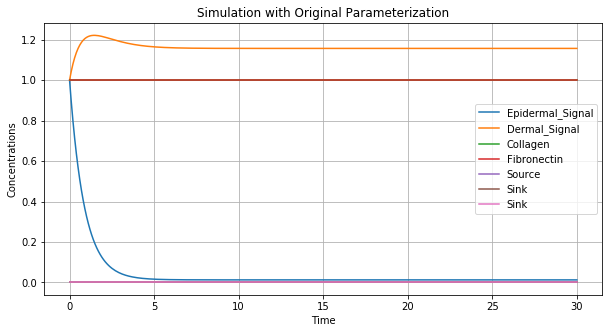

In [8]:
# Main
tVec = np.linspace(0, 30, 300)
# runModel(tVec, 0)   # Direct Sampling
runModel(tVec, 0)   # Null space sampling
plt.show()

### Recommended Implementation

#### Initialize SciPyModel

As we move forward it may be handy to write a script to execute these all. For now though it helps to keep things separate in case a change in one is required.

In [47]:
SciPyModel = SBML2SciPy.importSBMLFile(SBML2SciPy.createSciPyModel())
SciPyModel = SBML2SciPy.writeODEFunction(SciPyModel)
SciPyModel = SBML2SciPy.createNullSpaceFunction(SciPyModel)

#### Parameter Sampling

Here we can decide to either use the direct sampling, or the nullspace-informed sampling (should come up with an acronym for that).

In [48]:
import numpy

# Set number of samples to draw
SciPyModel.SimulationData.Sensitivity.Global.NumSamples = 10
# Set parameter bounds
SciPyModel.Parameters.MinimumValue = numpy.zeros(SciPyModel.Parameters.Quantity)
SciPyModel.Parameters.MaximumValue = numpy.ones(SciPyModel.Parameters.Quantity) * 2.

# LHSU Method
SciPyModel = SBML2SciPy.sampleLHSU( SciPyModel )

# NI-LHSU Method
# SciPyModel = SBML2SciPy.sampleNullSpace( SciPyModel )

#### Parameter Estimation

I really like your approach here. Once we have our workflow established this will let us implement a parallel loop to see if there are multiple sets that fit the criteria.

In [55]:
ParamIdx = -1

ParamSet = SciPyModel.Parameters.Value

SciPyModel.Parameters.Value = (
    SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[0, :])


SciPyModel.SimulationData.TimeStart = 0
SciPyModel.SimulationData.TimeEnd = 30
SciPyModel.SimulationData.DataPoints = 100

SciPyModel = SBML2SciPy.integrateODEFunction(SciPyModel)

tIdx = np.where(
        np.round(
            SciPyModel.SimulationData.Deterministic.TimeVector, decimals=1) ==
        25)

In [56]:
print tIdx

(array([], dtype=int64),)


In [ ]:
# Loop over sample space
for i in range(SciPyModel.SimulationData.Sensitivity.Global.NumSamples):
    SciPyModel.Parameters.Value = SciPyModel.SimulationData.Sensitivity.Global.ParameterSets[
        i, :]
    SciPyModel = SBML2SciPy.integrateODEFunction(
        SciPyModel)  # Solve system for given parameter set

    ## TEMP: currently finding first simulation/parameter set to give Kq >.95 @ t = 25
    tIdx = np.where(
        np.round(
            SciPyModel.SimulationData.Deterministic.TimeVector, decimals=1) ==
        25)
    if (SciPyModel.SimulationData.Deterministic.Data[tIdx,3] > 0.95) & \
            (SciPyModel.SimulationData.Deterministic.Data[tIdx,3] < 1.05):
        ParamIdx = i
        break

if ParamIdx < 0:
    print 'WARNING: No Parameter Set Found to Match Condition'
else:
    ParamSet = SciPyModel.Parameters.Value
    for i in range(len(ParamSet)):
        print SciPyModel.Parameters.MetaID[i],
        print('='),
        print ParamSet[i]
    plt.figure()
    plt.plot(SciPyModel.SimulationData.Deterministic.TimeVector,
             SciPyModel.SimulationData.Deterministic.Data)
    plt.legend(SciPyModel.Species.Names)
    plt.grid()

#### Notes

For a good chunk of this, I already implemented the methods in the SBML2SciPy script. That includes some rough help guidelines for understanding inputs. I haven't implemented all the conditionals to reject SciPyModel objects that don't have the required data, but when the code hits those points they are rather self-explanatory.

In [ ]:
help( SBML2SciPy.sampleLHSU )